## Spark ML using logistic Regression  
The problem here is to predict the grade (Passing or Failing) of City of Chicago restaurant inspections based on the notes made by the inspector.  

This uses logistic regression.  Suppose you have a set of feature vectors $x_i \in R^n$ for $i$ in in $[0,m]$.  Associated with each feature vector we have a binary result $y_i$.  We are interested in the probability $P(y =1 | x)$ which we write as the function $p(x)$. However because $p(x)$ is between 0 and 1 it is not expressable as a linear function of x so we can't use regular linear regression, so we look at the odds expression $p(x) / (1-p(x))$ and make the guess that its log is linear. In other words

$$ ln( \frac{p(x)}{1-p(x)}) = b_0 + b \cdot x$$

where the offset $b_0$ and the vector $b = [b_1, b_2, ... b_n]$ define a hyperplane for linear regression.  solving this for $p(x)$ we get

$$p(x) = \frac {1}{1+e^{-(b_0 + b \cdot x)}}  $$

And we say $y=1$  if $p(x)>0$  otherwise it is zero.   Unfortunately finding the best $b_0$ and $b$ is not as easy as straight linear regression, but simple Newton like iterations will converge to good solutions. 


We note that the logistic function $\sigma (t)$ is defined as follows:

$$\sigma (t)= \frac {e^t}{e^{t}+1} =\frac {1}{1+e^{-t}}$$

It is used frequently in machine learning to map a real number into a probabilty range $[0,1]$ .


 

In [1]:
sc

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

In [55]:
def csvParse(s):
    import csv
    from StringIO import StringIO
    sio = StringIO(s)
    value = csv.reader(sio).next()
    sio.close()
    return value

## The version in this notebook uses a slightly different input file from the one in the Azure HDInsight demo.   
This notebook will run on spark on your laptop.

In [225]:
#inspections = spark.sparkContext.textFile('wasb:///HdiSamples/HdiSamples/FoodInspectionData/Food_Inspections1.csv')\
#                .map(csvParse)

inspections = spark.sparkContext.textFile('/users/dennisgannon/OneDrive/Docs7/Food_Inspections1.csv')\
                .map(csvParse)

In [226]:
inspections.count()

103994

In [296]:
inspections.take(10)

[['1978294',
  'KFC',
  'KENTUCKY FRIED CHICKEN',
  'Pass',
  '32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: OBSERVED THE FLOUR BIN BROKEN/CRACKED AT CHICKEN FRIED PREP AREA, INSTRUCTED TO REPLACE. | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: OBSERVED THE EXTERIOR OF THE FRYER, OVEN NOT CLEAN, INSTRUCTED TO CLEAN. ALSO CLEAN AND SANITIZE REAR CHICKEN PREP TABLE. | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: OBSERVED THE CEILING IN THE CHICKEN COOLER, NOT CLEAN, DUSTY. INSTRUCTED TO CLEAN. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: OBSERVED BROKEN LIGHT SHIELD IN LADIES RESTROOM, INSTRUCTED TO REPLACE. | 21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTENTIALLY HAZARDOUS FOODS ARE  PREPARED AND SERVED - Comments: VIOLATION CORRECTION'],
 ['1978279', 

In [231]:
schema = StructType([StructField("id", IntegerType(), False), 
                     StructField("name", StringType(), False), 
                     StructField("results", StringType(), False), 
                     StructField("violations", StringType(), True)])

df = spark.createDataFrame(inspections.map(lambda l: (int(l[0]), l[2], l[3], l[4])) , schema)
df.registerTempTable('CountResults')


In [275]:
df.show(5)

+-------+--------------------+---------------+--------------------+
|     id|                name|        results|          violations|
+-------+--------------------+---------------+--------------------+
|1978294|KENTUCKY FRIED CH...|           Pass|32. FOOD AND NON-...|
|1978279|          SOLO FOODS|Out of Business|                    |
|1978275|SHARKS FISH & CHI...|           Pass|34. FLOORS: CONST...|
|1978268|CARNITAS Y SUPERM...|           Pass|33. FOOD AND NON-...|
|1978261|            WINGSTOP|           Pass|                    |
+-------+--------------------+---------------+--------------------+
only showing top 5 rows



In [280]:
print("passing = %d"%df[df.results == 'Pass'].count())
print("failing = %d"%df[df.results == 'Fail'].count())

passing = 61204
failing = 20225


In [281]:
df.count()

103994

In [233]:
df.select('results').distinct().show()

+--------------------+
|             results|
+--------------------+
|           Not Ready|
|                Fail|
|            No Entry|
|Business Not Located|
|  Pass w/ Conditions|
|     Out of Business|
|                Pass|
+--------------------+



In [234]:
#%%sql -o count_results_df
count_results_df = spark.sql("SELECT results, COUNT(results) AS cnt FROM \
       CountResults GROUP BY results").toPandas()

In [235]:
count_results_df

,results,cnt
0,Not Ready,429
1,Fail,20225
2,No Entry,2678
3,Business Not Located,44
4,Pass w/ Conditions,9725
5,Out of Business,9689
6,Pass,61204


(-1.0101138270539849, 1.0, -1.0114322486525658, 1.0040925495551682)

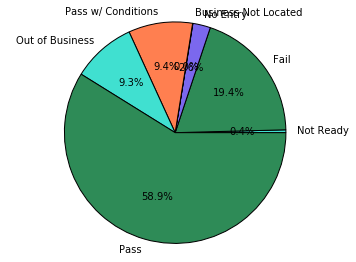

In [236]:
%matplotlib inline
import matplotlib.pyplot as plt


labels = count_results_df['results']
sizes = count_results_df['cnt']
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')

In [237]:
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData = df.select(label(df.results).alias('label'), df.violations).where('label >= 0')

In [238]:
labeledData.take(1)

[Row(label=1.0, violations=u'32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: OBSERVED THE FLOUR BIN BROKEN/CRACKED AT CHICKEN FRIED PREP AREA, INSTRUCTED TO REPLACE. | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: OBSERVED THE EXTERIOR OF THE FRYER, OVEN NOT CLEAN, INSTRUCTED TO CLEAN. ALSO CLEAN AND SANITIZE REAR CHICKEN PREP TABLE. | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: OBSERVED THE CEILING IN THE CHICKEN COOLER, NOT CLEAN, DUSTY. INSTRUCTED TO CLEAN. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: OBSERVED BROKEN LIGHT SHIELD IN LADIES RESTROOM, INSTRUCTED TO REPLACE. | 21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTENTIALLY HAZARDOUS FOODS ARE  PREPARED AND SERVED - Comments: VIOLATION CORRECTION')]

In [284]:
tokenizer = Tokenizer(inputCol="violations", outputCol="words")
#hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
hashingTF = HashingTF(inputCol="words", outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

model = pipeline.fit(labeledData)
model

PipelineModel_4b838c0e8fdc2048a099

In [285]:
hashingTF.getNumFeatures()

262144

In [295]:
testData = spark.sparkContext.textFile('/users/dennisgannon/OneDrive/Docs7/Food_Inspections2.csv')\
             .map(csvParse) \
             .map(lambda l: (int(l[0]), l[2], l[3], l[4]))
testDf = spark.createDataFrame(testData, schema).where("results = 'Fail' OR results = 'Pass' OR results = 'Pass w/ Conditions'")
predictionsDf = model.transform(testDf)
predictionsDf.registerTempTable('Predictions')
predictionsDf.columns

['id',
 'name',
 'results',
 'violations',
 'words',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [292]:
predictionsDf.take(1)

[Row(id=1978295, name=u'GREEN LINE FOOD MART, INC', results=u'Fail', violations=u'9. WATER SOURCE: SAFE, HOT & COLD UNDER CITY PRESSURE - Comments: OBSERVED NO RUNNING WATER AT ALL SINKS IN THE FACILITY. INSTRUCTED TO PROVIDE HOT AND COLD RUNNING WATER TO ALL SINKS (WASHBOWL, EXPOSED HAND SINK). CRITICAL VIOLATION 7-38-030 | 11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, DESIGNED, AND MAINTAINED - Comments: OBSERVED THE EMPLOYEE TOILET UNABLE TO FLUSH. INSTRUCTED TO REPAIR AND MAINTAIN THE TOILET. CRITICAL VIOLATION 7-38-030 | 27. TOILET ROOMS ENCLOSED CLEAN, PROVIDED WITH HAND CLEANSER, SANITARY HAND DRYING DEVICES AND PROPER WASTE RECEPTACLES - Comments: VIOLATION CORRECTED | 18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: VIOLATION CORRECTED | 21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTENTIALLY HAZARDOUS FOODS ARE  PREPARED AND SERVED - Comments: VIOLATION CORRECTED | 34. FLOORS: C

In [293]:
numSuccesses = predictionsDf.where("""(prediction = 0 AND results = 'Fail') OR 
                                      (prediction = 1 AND (results = 'Pass' OR 
                                                           results = 'Pass w/ Conditions'))""").count()
numInspections = predictionsDf.count()

print "There were", numInspections, "inspections and there were", numSuccesses, "successful predictions"
print "This is a", str((float(numSuccesses) / float(numInspections)) * 100) + "%", "success rate"


There were 30694 inspections and there were 27774 successful predictions
This is a 90.4867400795% success rate


In [243]:
from pyspark.sql.types import *
from IPython.core.magic import register_line_cell_magic

In [244]:
# Configuration parameters
max_show_lines = 50         # Limit on the number of lines to show with %sql_show and %sql_display
detailed_explain = True    

In [245]:
@register_line_cell_magic
def sql(line, cell=None):
    "Return a Spark DataFrame for lazy evaluation of the sql. Use: %sql or %%sql"
    val = cell if cell is not None else line 
    print val
    return sqlContext.sql(val)

@register_line_cell_magic
def sql_show(line, cell=None):
    "Execute sql and show the first max_show_lines lines. Use: %sql_show or %%sql_show"
    val = cell if cell is not None else line 
    return sqlContext.sql(val).show(max_show_lines) 

@register_line_cell_magic
def sql_display(line, cell=None):
    """Execute sql and convert results to Pandas DataFrame for pretty display or further processing.
    Use: %sql_display or %%sql_display"""
    val = cell if cell is not None else line 
    return sqlContext.sql(val).limit(max_show_lines).toPandas() 


In [246]:
#%%sql -q -o true_positive
#SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND results = 'Fail'
true_negative = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE \
        (prediction = 0 AND results = 'Fail')").toPandas()

In [247]:
#%%sql -q -o false_positive
false_negative = spark.sql("SELECT count(*) AS cnt FROM Predictions \
WHERE prediction = 0 AND (results = 'Pass' OR results = 'Pass w/ Conditions')").toPandas()

In [248]:
#%%sql -q -o true_negative
false_positive = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE \
       prediction = 1 AND results = 'Fail' ").toPandas()

In [249]:
#%%sql -q -o false_negative
true_positive = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE \
      prediction = 1 AND (results = 'Pass' OR results = 'Pass w/ Conditions')").toPandas()

In [250]:
false_negative['cnt']

0    677
Name: cnt, dtype: int64

(-1.0045326948165894, 1.0, -1.0032166242599487, 1.0048178434371948)

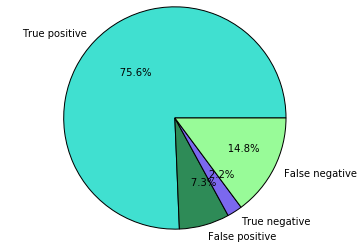

In [251]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = ['True positive', 'False positive', 'True negative', 'False negative']
sizes = [true_positive['cnt'], false_positive['cnt'], false_negative['cnt'], true_negative['cnt']]
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%10.1f%%', colors=colors)
plt.axis('equal')

Precision and recall are then defined as:

$$Precision=\frac {tp}{tp+fp}$$


$$ Recall = \frac {tp}{tp+fn} $$


Precision is the probability that a (randomly selected) positive prediction is correct.

Recall is the probability that a (randomly selected) resturant with a passing grade is predicted to be passing.


In [252]:
print('so precision = %f'% \
      (float(true_positive['cnt'])/(float(true_positive['cnt'])+float(false_positive['cnt']))))

so precision = 0.911911


In [253]:
print('and recall = %f'% \
      (float(true_positive['cnt'])/(float(true_positive['cnt'])+float(false_negative['cnt']))))

and recall = 0.971670


If we do this another way, we can ask how accurate are we in finding the failing resturants? This is a bit harder because there are far fewer of them.   In this case we are interested in true-negatives, so 

Precision is the probability that a (randomly selected) negative prediction is correct.

Recall is the probability that a (randomly selected) resturant with a failing grade is predicted to be failing.


$$Precision=\frac {tn}{tn+fn}$$


$$ Recall = \frac {tn}{tn+fp} $$


In [254]:
print('so the precision of failure prediction = %f'% \
      (float(true_negative['cnt'])/(float(true_negative['cnt'])+float(false_negative['cnt']))))

so the precision of failure prediction = 0.870579


In [255]:
print('and recall is = %f'% \
      (float(true_negative['cnt'])/(float(true_negative['cnt'])+float(false_positive['cnt']))))

and recall is = 0.670001
